In [63]:
import pandas as pd
import numpy as np
from src.scoring import *
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_roc_curve
import seaborn as sn

%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [33]:
df = pd.read_csv('data/Task2data.csv')
y = df.pop('fraud')
df.head()

,amount,hour,zip1,id#,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,field1_0,field1_1,field1_2,field1_3
0,12.95,0,986,1234567890123456,0,0,-723,19,0,0,0,0,0,1,1,0,0,0
1,38.85,0,980,1234567890123457,1,0,5497,14,1,0,0,1,0,1,0,0,0,1
2,38.85,0,402,1234567890123458,1,0,-4420,23,0,0,1,1,0,1,0,0,1,0
3,12.95,0,958,1234567890123459,0,0,5010,31,0,0,1,0,0,1,0,0,0,1
4,38.85,0,300,1234567890123460,1,0,-4074,21,0,0,1,0,0,1,0,0,0,1


In [4]:
df.columns #PLUS ID!!!!!

Index(['amount', 'hour1', 'state1', 'zip1', 'custAttr1', 'custAttr2', 'field2',
       'hour2', 'flag1', 'field3', 'field4', 'indicator1', 'indicator2',
       'flag2', 'flag3', 'flag4', 'flag5', 'field3_scld', 'field4_sqd',
       'field4_log', 'zip_log', 'amount_root', 'field1__1', 'field1__2',
       'field1__3', 'field1__4'],
      dtype='object')

In [19]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [22]:
df.drop(columns=['custAttr2', 'state1', 'total'], inplace=True)

In [76]:
#We'll make 2 splits - our holdout will be our unseen data that we'll use later to compare all models
#X_main will be split further for model analysis
X_main, X_holdout, y_main, y_holdout = train_test_split(df, y, random_state=7, stratify=y)

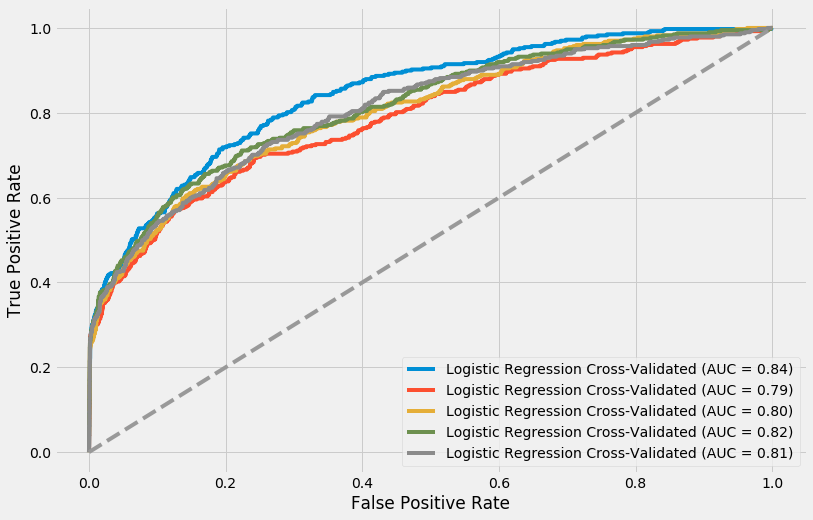

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))

kf = StratifiedKFold(n_splits=5, shuffle=True)
LR = LogisticRegression(solver='lbfgs',max_iter=10000, class_weight='balanced', tol=.0001)
scaler = StandardScaler()

for i, (train_index, test_index) in enumerate(kf.split(X_main, y_main)):
    X_train, X_test = X_main.iloc[train_index], X_main.iloc[test_index]
    y_train, y_test = y_main.iloc[train_index], y_main.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    LR.fit(X_train_scaled, y_train)
    plot_roc_curve(LR, X_test_scaled, y_test.values, name='Logistic Regression Cross-Validated', ax=ax)
    
ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')

In [60]:
for feature, coef in zip(df.columns, LR.coef_[0]):
    print (feature, ":", round(coef,4))

amount : -0.1785
hour : -0.0365
zip1 : 0.0623
id# : -0.1509
field2 : -0.1531
flag1 : 0.4716
field3 : 0.0771
field4 : -0.0024
indicator1 : 0.0778
indicator2 : 0.0508
flag2 : -0.595
flag3 : 0.1945
flag4 : -0.0604
flag5 : 0.4563
field1_0 : -0.8242
field1_1 : -0.5297
field1_2 : -1.268
field1_3 : -1.3483


In [73]:
X_main['']

,amount,hour,zip1,id#,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,field1_0,field1_1,field1_2,field1_3,amount_root
10385,38.85,23,890,1234567890132094,0,1,-3474,6,0,0,1,0,0,1,0,0,1,0,6.232977
20702,12.95,15,926,1234567890140074,0,1,-5501,9,0,0,1,1,0,1,0,0,0,1,3.598611
74893,12.95,16,300,1234567890179520,1,0,5861,26,0,0,0,1,0,1,0,0,0,1,3.598611
67728,25.90,13,989,1234567890174450,0,0,-7235,18,0,1,1,1,0,1,0,0,0,1,5.089204
45879,38.85,16,908,1234567890158795,1,0,-8732,16,0,0,1,1,0,2,0,0,0,1,6.232977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,49.95,1,537,1234567890131231,1,0,2276,9,1,0,0,0,0,2,0,0,1,0,7.067531
39900,49.95,18,945,1234567890132481,0,1,358,7,0,0,1,1,0,2,0,0,0,1,7.067531
23322,12.95,12,945,1234567890142080,0,1,4548,17,0,0,0,0,0,1,0,0,1,0,3.598611
56859,12.95,15,301,1234567890166732,1,0,25,18,0,0,0,0,0,1,0,0,1,0,3.598611
